In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from scipy.io import wavfile
import scipy.signal
import torch

from playback import make_playback_animation
from endoscopy import read_data



In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 24
})

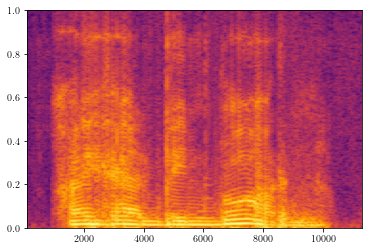

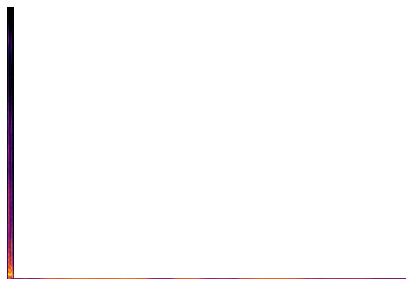

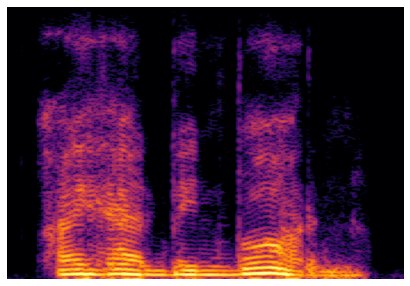

In [4]:
# comparison opus@6kb/s vs. LACE@6kb/s
for name in ['opus_6kbps', 'lace_6kbps']:
    fs, y = wavfile.read(f'lace_demo/{name}.wav')
    spec, freqs, t, im = plt.specgram(y, NFFT=512, cmap='inferno', noverlap=256 + 128, pad_to=4096)
    spec = 10*np.log10(spec)
    
    make_playback_animation(f'lace_demo/{name}_spec.mp4', spec, len(y)/16)

In [5]:
data = read_data('lace_demo/endoscopy/')

In [6]:
def get_adaconv_impz(data, prefix, frame_size=80, overlap_size=40):
    win1 = .5 + .5 * np.cos((np.arange(overlap_size) + 0.5) * torch.pi / overlap_size)
    win1 = win1[:, np.newaxis]
    win2 = win1[::-1]
    kernels = data[prefix + '_kernels']['data'][0] * data[prefix + '_gains']['data'][0, :, np.newaxis]
    kernels = kernels[:, ::-1]
    num_frames = len(kernels)
    impz = np.repeat(kernels, frame_size, 0)
    for i in range(num_frames - 2, 0, -1):
        idx = i * frame_size
        impz[idx : idx + overlap_size] = win2 * impz[idx : idx + overlap_size] + win1 * impz[idx - overlap_size : idx]
        
    return impz

In [7]:
def get_adacomb_impz(data, prefix, frame_size=80, overlap_size=40):
    win1 = .5 + .5 * np.cos((np.arange(overlap_size) + 0.5) * torch.pi / overlap_size)
    win1 = win1[:, np.newaxis]
    win2 = win1[::-1]
    kernels = data[prefix + '_kernels']['data'][0]
    gg = data[prefix + '_global_conv_gains']['data'][0]
    g  = data[prefix + '_gains']['data'][0]
    lags = data[prefix + '_lags']['data'][0]
    
    num_frames = len(kernels)
    max_lag = int(lags.max())
    kernel_size = kernels.shape[1]
    padding = kernel_size // 2
    
    impz = np.zeros((num_frames, max_lag + padding + 1))
    for i in range(num_frames):
        p = int(lags[i])
        impz[i, 0] = gg[i]
        impz[i, p - padding : p - padding + kernel_size] = gg[i] * g[i] * kernels[i, ::-1]
    
    impz = np.repeat(impz, frame_size, 0)
    for i in range(num_frames - 2, 0, -1):
        idx = i * frame_size
        impz[idx : idx + overlap_size] = win2 * impz[idx : idx + overlap_size] + win1 * impz[idx - overlap_size : idx]
    
    return impz

In [8]:
impz_comb1 = get_adacomb_impz(data, 'limited_adaptive_comb1d_1')
impz_comb2 = get_adacomb_impz(data, 'limited_adaptive_comb1d_2')
impz_conv1 = get_adaconv_impz(data, 'limited_adaptive_conv1d_1')

phi = data['hidden_features']['data'][0, 0]

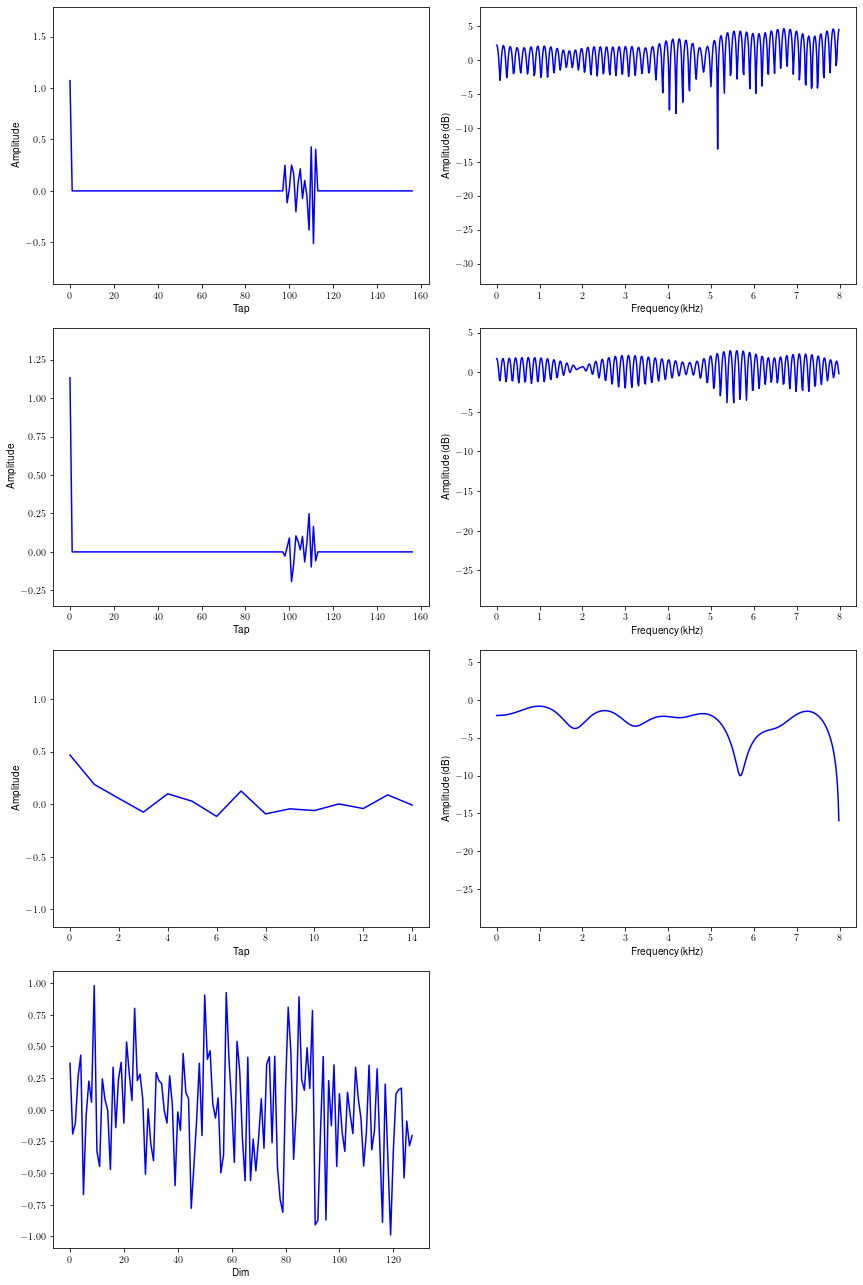

In [9]:
# LACE animation

fig, axs = plt.subplots(4, 2)
frame_duration=40
fig.set_size_inches(12, 18)
axs[0, 0].set_xlabel('Tap')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 1].set_xlabel('Frequency (kHz)')
axs[0, 1].set_ylabel('Amplitude (dB)')
axs[1, 0].set_xlabel('Tap')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 1].set_xlabel('Frequency (kHz)')
axs[1, 1].set_ylabel('Amplitude (dB)')
axs[2, 0].set_xlabel('Tap')
axs[2, 0].set_ylabel('Amplitude')
axs[2, 1].set_xlabel('Frequency (kHz)')
axs[2, 1].set_ylabel('Amplitude (dB)')
axs[3, 0].set_xlabel('Dim')
axs[3, 1].set_visible(False)
fig.tight_layout()

frames = []
for i in range(12800, 14000, 4):
    f = impz_comb1[i]
    w, h = scipy.signal.freqz(f, fs=16000)
    frame = axs[0, 0].plot(f, 'b') + axs[0, 1].plot(w/1000, 10 * np.log10(np.abs(h)), 'b')
    
    f = impz_comb2[i]
    w, h = scipy.signal.freqz(f, fs=16000)
    frame += axs[1, 0].plot(f, 'b') + axs[1, 1].plot(w/1000, 10 * np.log10(np.abs(h)), 'b')
    
    f = impz_conv1[i]
    w, h = scipy.signal.freqz(f, fs=16000)
    frame += axs[2, 0].plot(f, 'b') + axs[2, 1].plot(w/1000, 10 * np.log10(np.abs(h)), 'b')
    
    frame += axs[3, 0].plot(phi[i//80], 'b')
    
    frames.append(frame)
    
ani = matplotlib.animation.ArtistAnimation(fig, frames, blit=True, interval=frame_duration)
ani.save('lace_demo/responses2.mp4', dpi=720)

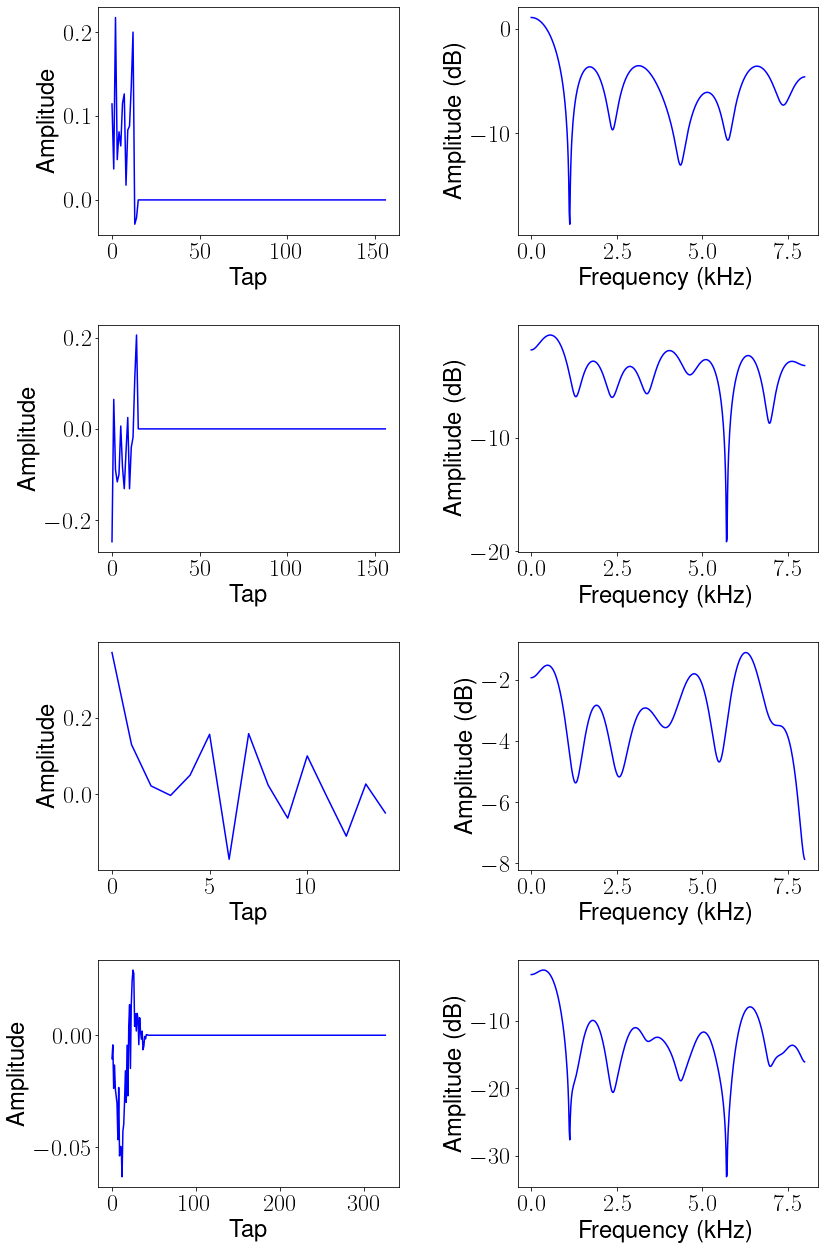

In [16]:
# static plot for Jean-Marc's on-site presentation

fig, axs = plt.subplots(4, 2)
frame_duration=40
fig.set_size_inches(12, 18)
axs[0, 0].set_xlabel('Tap')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 1].set_xlabel('Frequency (kHz)')
axs[0, 1].set_ylabel('Amplitude (dB)')
axs[1, 0].set_xlabel('Tap')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 1].set_xlabel('Frequency (kHz)')
axs[1, 1].set_ylabel('Amplitude (dB)')
axs[2, 0].set_xlabel('Tap')
axs[2, 0].set_ylabel('Amplitude')
axs[2, 1].set_xlabel('Frequency (kHz)')
axs[2, 1].set_ylabel('Amplitude (dB)')
axs[3, 0].set_xlabel('Tap')
axs[3, 0].set_ylabel('Amplitude')
axs[3, 1].set_xlabel('Frequency (kHz)')
axs[3, 1].set_ylabel('Amplitude (dB)')
fig.tight_layout()
i=10*80

f = impz_comb1[i]
w, h = scipy.signal.freqz(f, fs=16000)
axs[0, 0].plot(f, 'b')
axs[0, 1].plot(w/1000, 10 * np.log10(np.abs(h)), 'b')

f = impz_comb2[i]
w, h = scipy.signal.freqz(f, fs=16000)
axs[1, 0].plot(f, 'b')
axs[1, 1].plot(w/1000, 10 * np.log10(np.abs(h)), 'b')

f = impz_conv1[i]
w, h = scipy.signal.freqz(f, fs=16000)
axs[2, 0].plot(f, 'b')
axs[2, 1].plot(w/1000, 10 * np.log10(np.abs(h)), 'b')

f = np.convolve(np.convolve(impz_comb1[i], impz_comb2[i], mode='full'), impz_conv1[i])
w, h = scipy.signal.freqz(f, fs=16000)
axs[3, 0].plot(f, 'b')
axs[3, 1].plot(w/1000, 10 * np.log10(np.abs(h)), 'b')

fig.savefig('plots/lace_snapshot_unvoiced.png')